In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemFD, GlobalEM1DSurveyFD, get_vertical_discretization_frequency
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import empymod

# Seting up a 2D mesh and model

In [3]:
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.01)

In [4]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

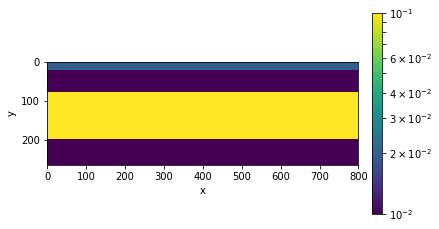

In [5]:
n_sounding = 40
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 200.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 0.1
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()
chi = np.zeros_like(sigma_em1d)
# chi[poly_inds] = 0.005
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [9]:
x = mesh.vectorCCx
y = np.zeros_like(x)
perturb = 20.
z = np.ones_like(x) * 30.

rx_locations = np.c_[x, y, z+20]
src_locations = np.c_[x, y, z+20]
topo = np.c_[x, y, z-30.].astype(float)

In [10]:
mapping = Maps.ExpMap(mesh)
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "ppm",
    field_type = 'secondary',
    topo = topo
)
prob = GlobalEM1DProblemFD(
    [], sigmaMap=mapping, chi=chi, hz=hz, parallel=False, n_cpu=6, verbose=False,
    Solver=PardisoSolver
)
prob.pair(survey)
m = np.log(sigma_em1d)
dobs = survey.makeSyntheticData(m, std=0.05)
# dobs = survey.dpred(m)

>> Serial version is used


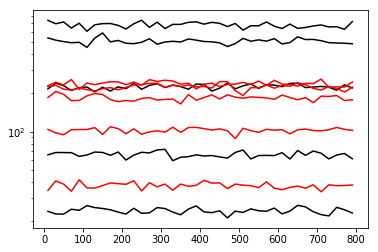

In [11]:
DOBS = dobs.reshape(( prob.n_sounding, 2, survey.n_frequency))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'r')    

In [12]:
def get_data_frequency_index(dobs, n_sounding, frequency, frequency_index):
    n_frequency = frequency.size
    DOBS = dobs.reshape((n_sounding, 2, n_frequency))
    return DOBS[:,:,frequency_index].flatten()
frequency_index = [4]
dobs_reduced = get_data_frequency_index(dobs, n_sounding, frequency, frequency_index)

In [13]:
hz = np.r_[1.]
mapping = Maps.ExpMap(nP=n_sounding)

wires = Maps.Wires(('sigma', n_sounding),('h', n_sounding))
expmap = Maps.ExpMap(nP=n_sounding)
sigmaMap = expmap * wires.sigma

survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency[frequency_index],
    offset = np.ones_like(frequency[frequency_index]) * 7.86,
    src_type = "VMD",
    rx_type = "ppm",
    field_type = 'secondary',
    topo = topo, 
    half_switch=True
)
prob = GlobalEM1DProblemFD(
    [], sigmaMap=sigmaMap, hMap=wires.h, hz=hz, parallel=False, n_cpu=2, verbose=True,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Serial version is used


In [14]:

e = np.ones(n_sounding)
m0 = np.r_[e*np.log(1./100.), e*30]
d0 = survey.dpred(m0)

Compute fields
>> Compute response


In [15]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)
from simpegEM1D import get_2d_mesh, LateralConstraint

In [16]:
hz

array([1.])

In [23]:
mesh_reg = get_2d_mesh(n_sounding, np.r_[1])
# mapping is required ... for IRLS
reg_sigma = LateralConstraint(
    mesh_reg, mapping=wires.sigma,
    alpha_s=1,
    alpha_x = 1.,
    alpha_y = 1.,    
)
reg_sigma.get_grad_horizontal(topo, hz, dim=2)
regmap_height = Maps.IdentityMap(mesh_reg)
# mapping is required ... for IRLS
reg_height = LateralConstraint(
    mesh_reg, mapping=wires.h,
    alpha_s=0.,
    alpha_x = 1.,
    alpha_y = 1.,    
)
reg_height.get_grad_horizontal(topo, hz, dim=2)
reg = reg_sigma + reg_height

In [24]:
%%time
std = 0.1
floor = 0.
np.random.seed(1)

e = np.ones(n_sounding)
m0 = np.r_[e*np.log(1./500.), e*30]

uncert = std*abs(dobs_reduced)+floor
survey.dobs = dobs_reduced.copy()
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1, fix_Jmatrix=True, betaSearch=False
)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target = Directives.TargetMisfit()
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=0)
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, beta,target])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
# invProb.beta = 0.
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Compute fields
>> Compute response
>> Compute J sigma
>> Compute J height
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.44e+04  0.00e+00  2.44e+04    3.61e+03      0              
Compute fields
>> Compute response
>> Compute J sigma
>> Compute J height
   1  0.00e+00  3.29e+03  9.57e-25  3.29e+03    3.38e+02      0              
Compute fields
>> Compute response
>> Compute J sigma
>> Compute J height
   2  0.00e+00  2.29e+02  5.6

(0, 100)

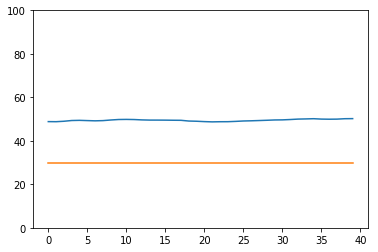

In [25]:
plt.plot(prob.hMap * mopt)
plt.plot(prob.hMap * m0)
plt.ylim(0, 100)

(0.001, 1)

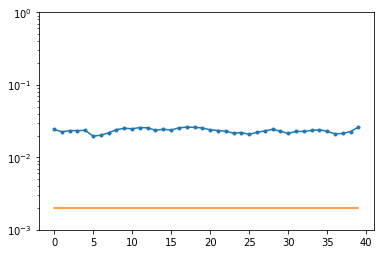

In [26]:
plt.semilogy(prob.sigmaMap * mopt, '.-')
plt.plot(prob.sigmaMap * m0)
plt.ylim(0.001, 1)

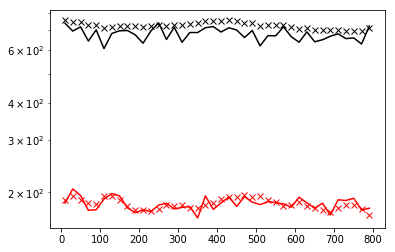

In [27]:
DOBS = dobs_reduced.reshape(( prob.n_sounding, 2, len(frequency_index)))
DPRED = invProb.dpred.reshape((prob.n_sounding, 2, len(frequency_index)))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
    plt.semilogy(mesh.vectorCCx, DPRED[:,0,i_freq], 'kx')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'r')
    plt.semilogy(mesh.vectorCCx, DPRED[:,1,i_freq], 'rx')
plt.yscale('log')